In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import ops
from geographiclib.geodesic import Geodesic
from shapely.geometry import LineString, MultiLineString
from scipy.ndimage.filters import gaussian_filter

def raster_filter_range(raster0, g1, g2):
    raster = raster0.copy()
    raster.values = raster.values.astype(np.float32)
    raster.values = gaussian_filter(raster.values,g1) - gaussian_filter(raster.values,g2)
    return raster

# helper function
def segmentize(line):
    return list(map(LineString, zip(line.coords[:-1], line.coords[1:])))

def inverse_radian_km(geom):
    # [[lon0, lat0], [lon1, lat1]]
    coords = np.asarray(geom.coords).ravel()
    #g = geod.Inverse(float(xy0.y), float(xy0.x), float(xy1.y), float(xy1.x))
    g = geod.Inverse(coords[1], coords[0], coords[3], coords[2])
    radian = np.pi*(90 + g['azi1'])/180
    radian = radian if radian<=np.pi else radian-2*np.pi
    return (radian, g['s12']/1000.0)

def angle_radian(geom):
    return inverse_radian_km(geom)[0]

def length_km(geom):
    return inverse_radian_km(geom)[1]

In [2]:
# plotting modules
import matplotlib.pyplot as plt
from matplotlib import cm, colors
%matplotlib inline

## Define Parameters

In [3]:
# Gaussian filter band width
dsigmakm = 20
# iso interval, m
interval = 10
# Gaussian filter band cental sigma, km
sigmaskm = np.linspace(20,980,49)
sigmaskm

array([ 20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200., 220.,
       240., 260., 280., 300., 320., 340., 360., 380., 400., 420., 440.,
       460., 480., 500., 520., 540., 560., 580., 600., 620., 640., 660.,
       680., 700., 720., 740., 760., 780., 800., 820., 840., 860., 880.,
       900., 920., 940., 960., 980.])

In [4]:
# Gaussian filter band width
dsigmakm = 10
# iso interval, m
interval = 10
# Gaussian filter band cental sigma, km
sigmaskm = np.linspace(5,100,20)
sigmaskm

array([  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,
        60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

## Read Raster

In [5]:
# grav_29.1.10min.nc regridded from Open Sandwell and Smith Global Gravity Grid grav_29.1nc
da = xr.open_dataarray('grav_29.1.10min.nc').squeeze(drop=True)
da

<xarray.DataArray (lat: 960, lon: 2160)>
[2073600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.8 179.9
  * lat      (lat) float64 -79.92 -79.75 -79.58 -79.42 ... 79.58 79.75 79.92

sigmakm 5.0
radius range 0.0 0.5999999999999318
-114.07957458496094 147.08282470703125
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 118945
geometries 2120952


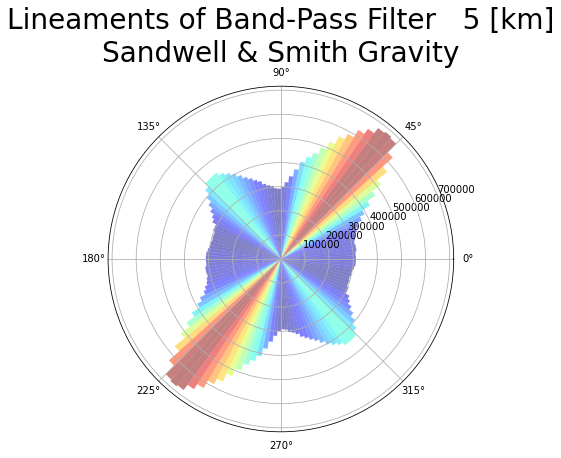

sigmakm 10.0
radius range 0.2999999999999659 0.8999999999998977
-173.43807983398438 227.9222869873047
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 170571
geometries 2496832


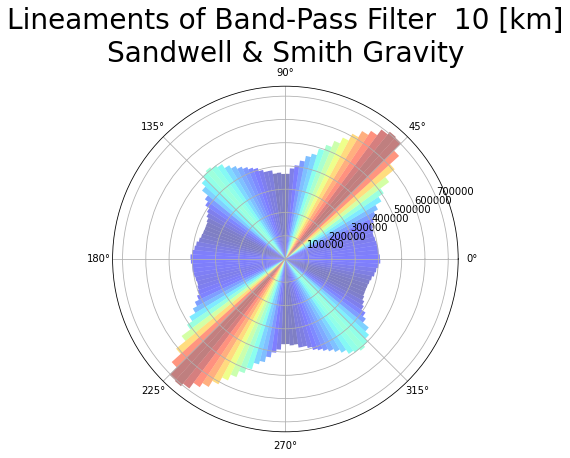

sigmakm 15.0
radius range 0.5999999999999318 1.1999999999998636
-100.33544158935547 168.76394653320312
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 70098
geometries 1622130


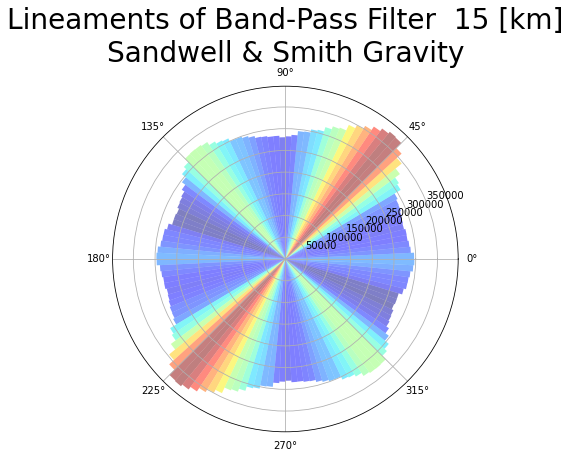

sigmakm 20.0
radius range 0.8999999999998977 1.4999999999998295
-68.54244232177734 140.39569091796875
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 32630
geometries 1167356


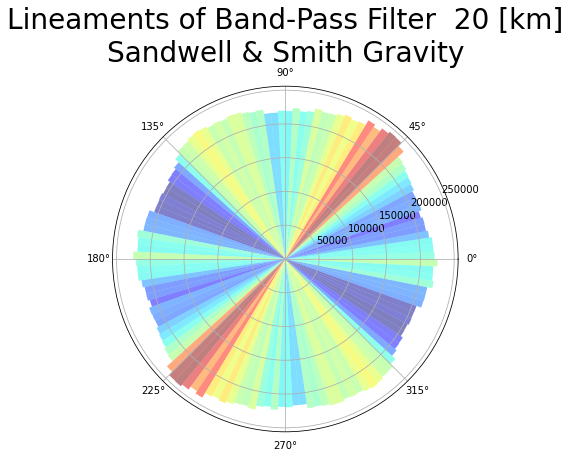

sigmakm 25.0
radius range 1.1999999999998636 1.7999999999997953
-58.03619384765625 117.78494262695312
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 18435
geometries 920542


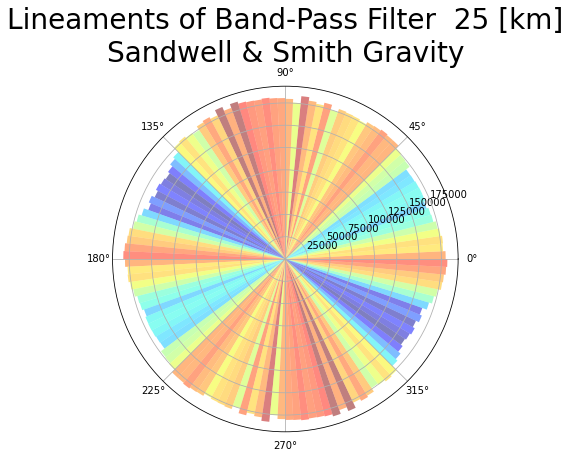

sigmakm 30.0
radius range 1.4999999999998295 2.099999999999761
-51.91620635986328 98.72941589355469
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 11538
geometries 756663


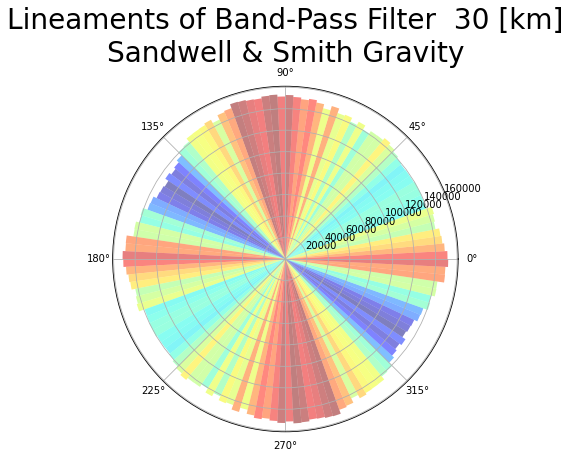

sigmakm 35.0
radius range 1.7999999999997953 2.3999999999997272
-44.39991760253906 86.53256225585938
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 7647
geometries 642156


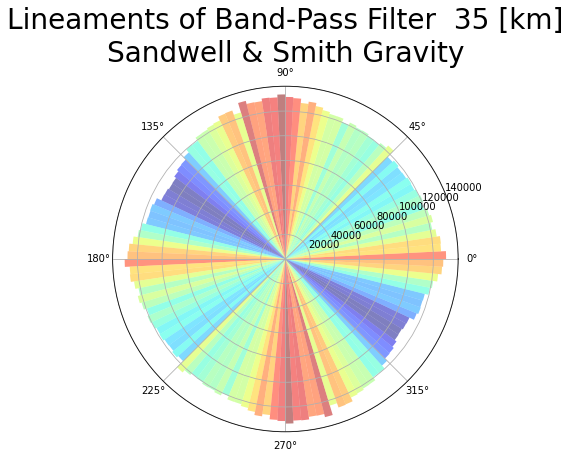

sigmakm 40.0
radius range 2.099999999999761 2.699999999999693
-39.86271667480469 77.59730529785156
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 5421
geometries 557958


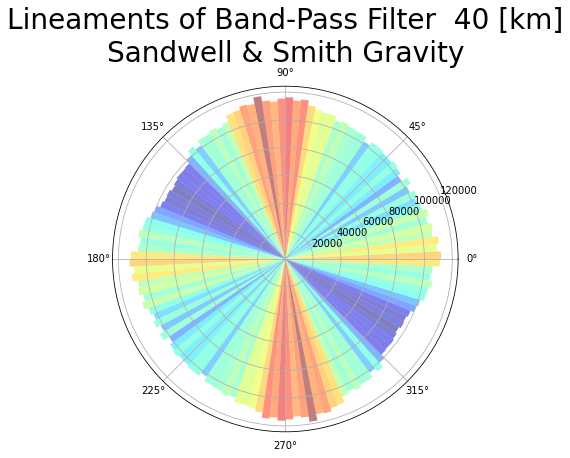

sigmakm 45.0
radius range 2.3999999999997272 2.999999999999659
-37.07843017578125 68.0458984375
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 4066
geometries 494264


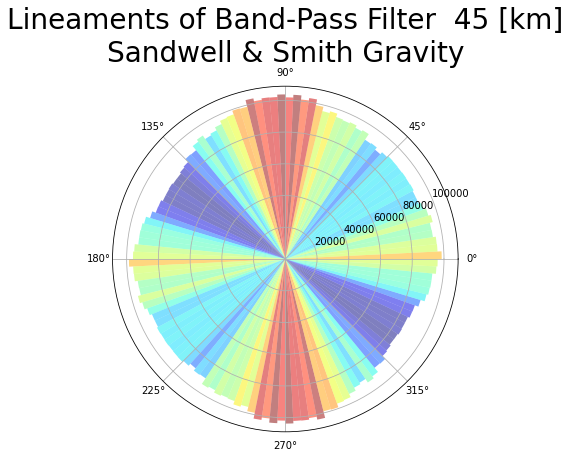

sigmakm 50.0
radius range 2.699999999999693 3.299999999999625
-34.50274658203125 58.87367248535156
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 3163
geometries 442931


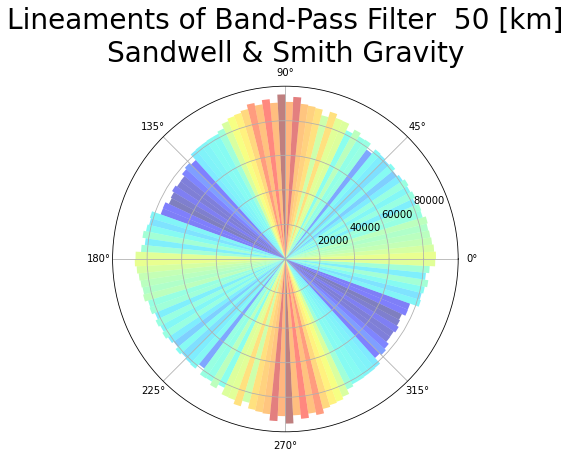

sigmakm 55.0
radius range 2.999999999999659 3.5999999999995906
-31.83080291748047 50.5963134765625
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 2520
geometries 401602


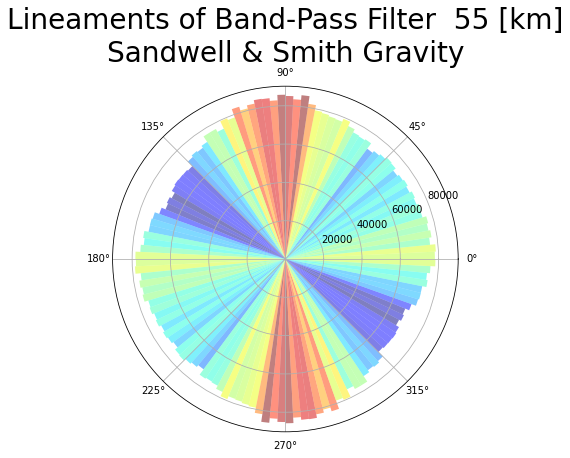

sigmakm 60.0
radius range 3.299999999999625 3.8999999999995567
-30.79637908935547 43.24021911621094
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 2043
geometries 368565


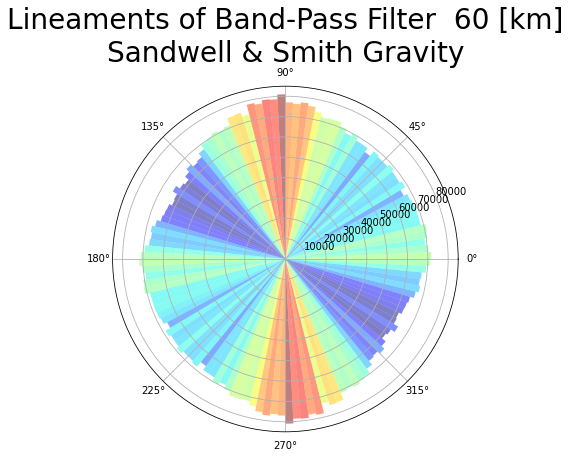

sigmakm 65.0
radius range 3.5999999999995906 4.199999999999522
-29.068588256835938 36.913673400878906
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 1753
geometries 340344


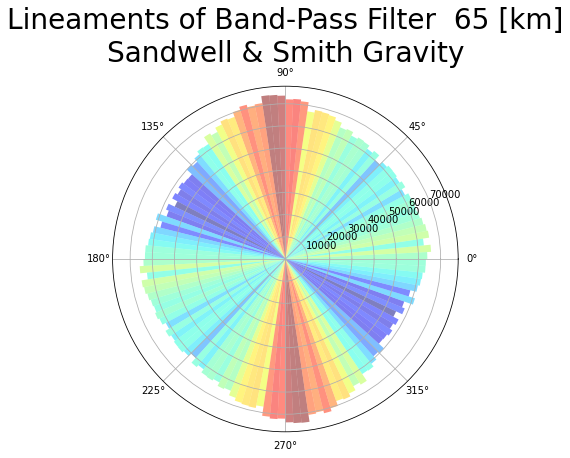

sigmakm 70.0
radius range 3.8999999999995567 4.499999999999488
-27.32769012451172 31.524917602539062
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 1490
geometries 315814


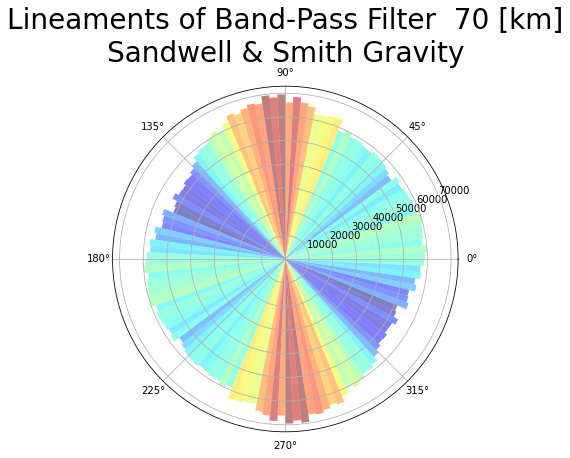

sigmakm 75.0
radius range 4.199999999999522 4.7999999999994545
-25.303939819335938 27.024795532226562
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 1345
geometries 293730


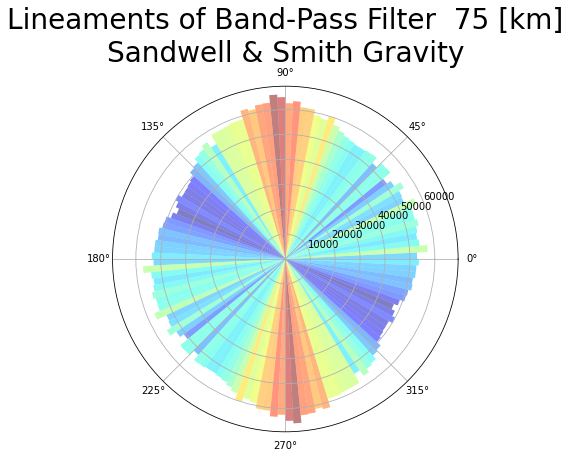

sigmakm 80.0
radius range 4.499999999999488 5.0999999999994206
-23.139453887939453 23.31134796142578
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 1140
geometries 274084


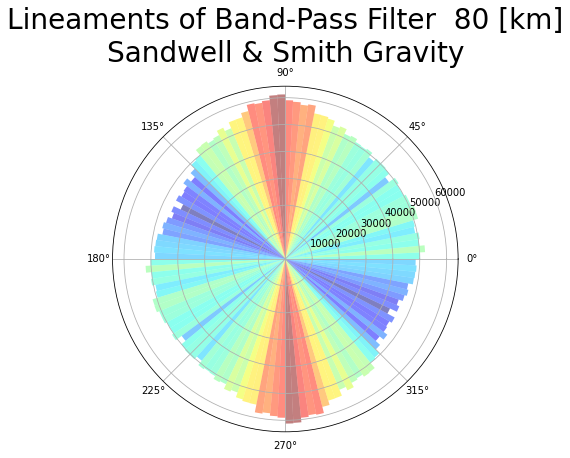

sigmakm 85.0
radius range 4.7999999999994545 5.399999999999386
-20.98101043701172 20.124778747558594
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 1014
geometries 256982


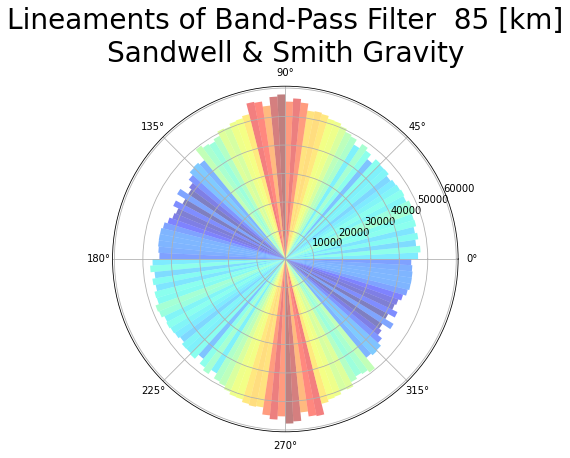

sigmakm 90.0
radius range 5.0999999999994206 5.699999999999352
-19.01561737060547 17.38671875
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 904
geometries 241771


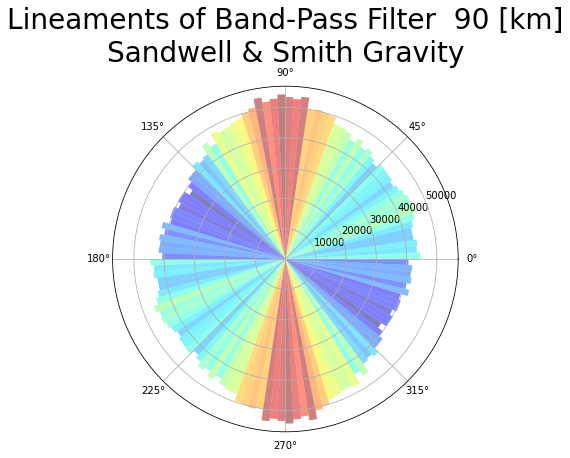

sigmakm 95.0
radius range 5.399999999999386 5.999999999999318
-17.37228775024414 15.035675048828125
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 771
geometries 228254


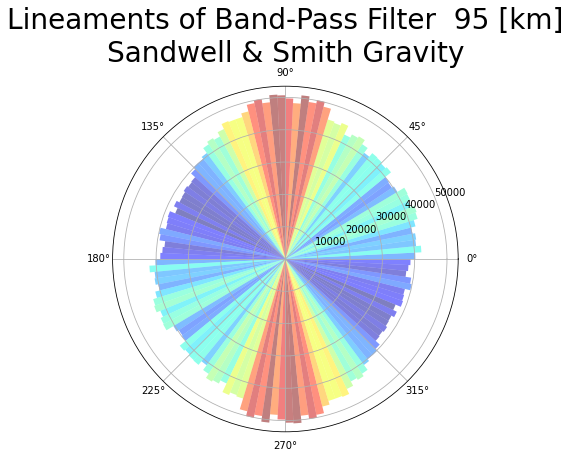

sigmakm 100.0
radius range 5.699999999999352 6.299999999999284
-15.815338134765625 13.027297973632812
0...10...20...30...40...50...60...70...80...90...100 - done.
geometries 686
geometries 216215


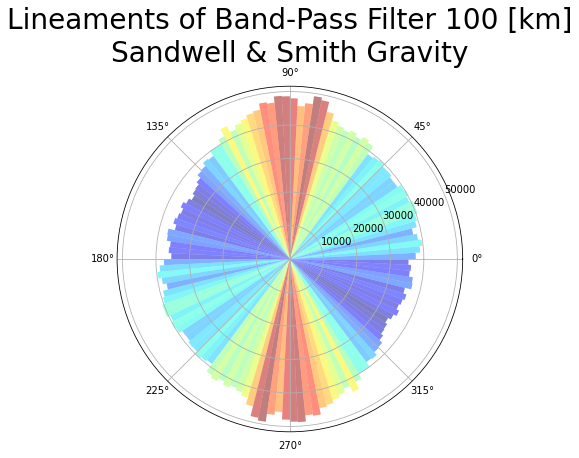

In [6]:
# for inverse geodetic calculation
geod = Geodesic.WGS84

for sigmakm in sigmaskm:
    print ("sigmakm", sigmakm)
    # roughly estimate filtering radius in pixels
    radius0 = float((sigmakm-dsigmakm/2)/(100*da.lon.diff(dim='lon'))[0])
    radius1 = float((sigmakm+dsigmakm/2)/(100*da.lon.diff(dim='lon'))[0])
    print ("radius range", radius0, radius1)

    raster = raster_filter_range(da, radius0, radius1)
    print (float(raster.min()), float(raster.max()))
    #raster.plot()

    !rm -fr grav_29.1.10min.bandpass.nc
    raster.to_netcdf('grav_29.1.10min.bandpass.nc')

    #interval = float(raster.max()-raster.min())/64
    #print ("interval", interval)
    !gdal_contour -a z -i {interval} grav_29.1.10min.bandpass.nc grav_29.1.10min.bandpass.shp

    df = gpd.read_file('grav_29.1.10min.bandpass.shp')
    df.geometry = df.geometry.apply(lambda geom: MultiLineString([geom]) if geom.geom_type == 'LineString' else geom)
    df = df.explode("geometry").reset_index(drop=True)
    print ("geometries",len(df))

    df['geom'] = df.geometry.apply(lambda geom: segmentize(geom))
    df = df.explode("geom").reset_index(drop=True)
    df = df.rename(columns={'geometry':'_','geom': 'geometry'}).drop(['_'], axis=1)
    print ("geometries",len(df))

    df['angle'] = df.geometry.apply(angle_radian)
    df['length'] = df.geometry.apply(length_km)

    # symmetrize directions
    _df = df.copy()
    _df['angle'] = df.angle.apply(lambda radian: radian-np.pi if radian>=0 else np.pi+radian)
    df_sym = pd.concat([df, _df])

    # Pandas 0.25.0+
    angles = np.linspace(-np.pi, np.pi, 128+1, endpoint=True)
    labels = (angles[1:] + angles[:-1])/2
    df_sym['sector'] = labels[np.digitize(df_sym.angle, angles)-1]
    df_sym_sector = df_sym.groupby(['sector']).agg(num = ('sector','count'),length = ('length','sum')).reset_index()

    # force square figure and square axes looks better for polar, IMO
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

    theta = df_sym_sector.sector.values
    radii = df_sym_sector.length.values
    width = np.diff(angles)[0]

    bars = ax.bar(theta, radii, width=width, bottom=0.0)
    for r,bar in zip(radii, bars):
        bar.set_facecolor( cm.jet((r-np.min(radii))/(np.max(radii)-np.min(radii))))
        bar.set_alpha(0.5)

    plt.title(f'Lineaments of Band-Pass Filter {int(sigmakm): >3} [km]\nSandwell & Smith Gravity', fontsize=28)
    plt.savefig(f'Lineaments of Band-Pass Filter {int(sigmakm):0>3} [km] Sandwell & Smith Gravity.jpg', \
                bbox_inches='tight', dpi=100, pil_kwargs={'quality': 85})
    plt.show()